# Atividade Prática - Redes Neurais

Nesta atividade, você irá utilizar redes neurais para detectar malária em esfregaços de sangue. Os dados utilizados foram coletados e classificados por pesquisadores do Centro Nacional de Comunicações Biomédicas de Lister Hill (LHNCBC), e contém 27.558 imagens de células parasitadas e não infectadas. Mais informações sobre o dataset podem ser encontradas [aqui](https://lhncbc.nlm.nih.gov/publication/pub9932).
Utilize o código disponível neste notebook para baixar, classificar e separar os dados em treino, validação e teste.

Para realizar a atividade, siga os seguintes passos:

1. Treine uma regressão logística utilizando uma rede neural (uma rede somente com a camada de entrada e saída). 
2. Treine uma MLP de uma camada. Utilize Grid Search (dica: use o Talos) para encontrar o número de neurônios, tamanho do batch e quantidade de épocas no treinamento.
3. Treine as seguintes arquiteturas de CNN:
  * Uma única camada com 32 filtros 3x3
  * Duas camadas com 32 filtros 3x3
  * Três camadas: duas de 32 filtros 3x3 e uma de 64 filtros 3x3
  * Quatro camadas: duas de 32 filtros 3x3 e duas de 64 filtros 3x3

  Todas as camadas convolucionais devem ser seguidas de Max Pooling com filtro 2x2. Teste diferentes quantidades de neurônios para a camada densa.
4. Utilize Data Augmentation para tentar melhorar os resultados encontrados.

Algumas observações:
* Todas as redes devem ser avaliadas em treino, validação e teste
* Plote gráficos para a evolução de acurácia e perda dos modelos durante o treinamento, comparando as métricas em treino e validação.
* Avalie e reporte se há indicação de Overfitting e justifique sua resposta.

**Bônus**: Utilize algumas técnicas para tratamento de overfitting nas redes criadas (e.g. L1, L2 e Dropout). 
  

In [0]:
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
!wget --no-check-certificate \
    ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip \
    -O cell_images.zip

--2020-03-23 12:58:45--  ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
           => ‘cell_images.zip’
Resolving lhcftp.nlm.nih.gov (lhcftp.nlm.nih.gov)... 130.14.55.35, 2607:f220:41e:7055::35
Connecting to lhcftp.nlm.nih.gov (lhcftp.nlm.nih.gov)|130.14.55.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Open-Access-Datasets/Malaria ... done.
==> SIZE cell_images.zip ... 353452851
==> PASV ... done.    ==> RETR cell_images.zip ... done.
Length: 353452851 (337M) (unauthoritative)

cell_images.zip     100%[===================>] 337.08M  92.8MB/s    in 3.9s    

2020-03-23 12:58:50 (86.1 MB/s) - ‘cell_images.zip’ saved [353452851]



In [0]:
!pip install talos split-folders tqdm

     |████████████████████████████████| 61kB 2.6MB/s 
     |████████████████████████████████| 378kB 10.2MB/s 
     |████████████████████████████████| 8.7MB 56.9MB/s 
     |████████████████████████████████| 109.2MB 39kB/s 
     |████████████████████████████████| 839kB 47.9MB/s 
     |████████████████████████████████| 3.2MB 47.7MB/s 
     |████████████████████████████████| 491kB 56.6MB/s 
  Created wheel for chances: filename=chances-0.1.9-cp36-none-any.whl size=41609 sha256=23bf2b6ae1a5eb7db3f3ec1084902cf4ac41f3c9560e22bdd5ef4a1a23a52fd2
  Stored in directory: /root/.cache/pip/wheels/75/33/46/c871b94249bd57d17797d049b3dff8e3a09c315afb67eb14c6
  Created wheel for astetik: filename=astetik-1.9.9-cp36-none-any.whl size=56960 sha256=da75be3faac16273e484de7ffdfa4bb73c3344b1accf9024cfc663896ea8b36b
  Stored in directory: /root/.cache/pip/wheels/ae/70/21/c475cd079ec401dd6e1b9b1d42b4c38554ce12679bfb214aad
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=5b

In [0]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
import talos

from keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
local_zip = './cell_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
!split_folders cell_images --output malaria --ratio .8 .1 .1

Copying files: 27560 files [00:03, 8642.30 files/s]


In [0]:
TRAIN_BATCH = len(os.listdir('./malaria/train/Parasitized')) + len(os.listdir('./malaria/train/Uninfected'))
VAL_BATCH = len(os.listdir('./malaria/val/Parasitized')) + len(os.listdir('./malaria/val/Uninfected'))
TEST_BATCH = len(os.listdir('./malaria/test/Parasitized')) + len(os.listdir('./malaria/test/Uninfected'))

In [0]:
train_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)
val_generator = ImageDataGenerator(rescale=1./255)

In [0]:
train_datagen = train_generator.flow_from_directory('./malaria/train',
                                                    target_size=(125, 125),
                                                    batch_size=TRAIN_BATCH,
                                                    class_mode='binary')

val_datagen = val_generator.flow_from_directory('./malaria/val',
                                                  target_size=(125,125),
                                                  batch_size=VAL_BATCH,
                                                  class_mode='binary')

test_datagen = test_generator.flow_from_directory('./malaria/test',
                                                   target_size=(125,125),
                                                   batch_size=TEST_BATCH,
                                                   class_mode='binary')

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [0]:
train_data, train_labels = train_datagen.next()
val_data, val_labels = val_datagen.next()
test_data, test_labels = test_datagen.next()

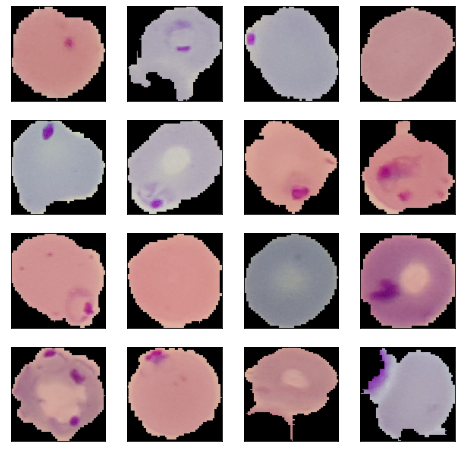

In [0]:
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.imshow(train_data[r[0]])
    plt.xticks([]) , plt.yticks([])

##1. Treine uma regressão logística utilizando uma rede neural (uma rede somente com a camada de entrada e saída). 

In [0]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(125, 125,3)),
    keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model1.fit(
      train_data, train_labels,
      epochs=30,
      validation_data=(val_data, val_labels),
      verbose=2)

Train on 22046 samples, validate on 2756 samples
Epoch 1/30
22046/22046 - 6s - loss: 0.9284 - acc: 0.5937 - val_loss: 0.9033 - val_acc: 0.5744
Epoch 2/30
22046/22046 - 4s - loss: 0.8678 - acc: 0.6138 - val_loss: 0.7498 - val_acc: 0.6477
Epoch 3/30
22046/22046 - 3s - loss: 0.8616 - acc: 0.6246 - val_loss: 0.9718 - val_acc: 0.5933
Epoch 4/30
22046/22046 - 4s - loss: 0.8508 - acc: 0.6314 - val_loss: 0.7182 - val_acc: 0.6557
Epoch 5/30
22046/22046 - 4s - loss: 0.8351 - acc: 0.6409 - val_loss: 1.4455 - val_acc: 0.5109
Epoch 6/30
22046/22046 - 4s - loss: 0.8311 - acc: 0.6438 - val_loss: 1.0103 - val_acc: 0.5809
Epoch 7/30
22046/22046 - 4s - loss: 0.8234 - acc: 0.6504 - val_loss: 0.8456 - val_acc: 0.6263
Epoch 8/30
22046/22046 - 4s - loss: 0.9054 - acc: 0.6470 - val_loss: 0.7176 - val_acc: 0.6713
Epoch 9/30
22046/22046 - 4s - loss: 0.7210 - acc: 0.6702 - val_loss: 0.8595 - val_acc: 0.6212
Epoch 10/30
22046/22046 - 4s - loss: 0.9020 - acc: 0.6581 - val_loss: 0.7624 - val_acc: 0.6419
Epoch 11/3

In [0]:
test_loss, test_acc = model1.evaluate(test_data,  test_labels, verbose=2)
print('\nTest model1 accuracy:', test_acc)

2756/2756 - 0s - loss: 0.9027 - acc: 0.6295

Test model1 accuracy: 0.62953556


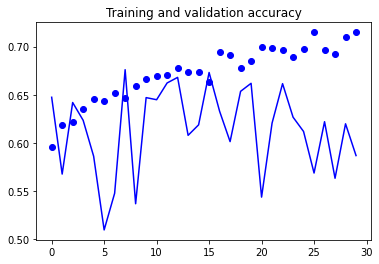

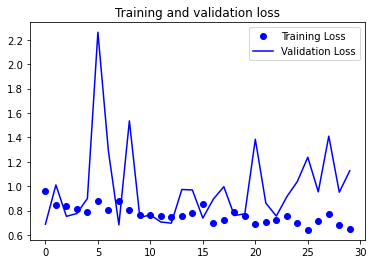

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##2. Treine uma MLP de uma camada. Utilize Grid Search (dica: use o Talos) para encontrar o número de neurônios, tamanho do batch e quantidade de épocas no treinamento.

In [0]:
p = {
    'first_neuron': [8, 16, 32],
    'batch_size': [8, 16, 32],
    'epochs': [10,20, 30]
}

In [0]:
from talos.utils import hidden_layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

In [0]:
def malaria_dataset(x_train, y_train, x_val, y_val, params):
     # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Flatten(input_shape=(125,125,3)))
    model.add(Dense(params['first_neuron'], activation='relu'))
    
    hidden_layers(model, params, 1)
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=[x_val, y_val],
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    verbose=0)
    
    # modify the output model
    return out, model

In [0]:
t = talos.Scan(
    x=train_data, 
    y=train_labels, 
    fraction_limit= 0.5, 
    params=p, 
    model=malaria_dataset, 
    experiment_name='malaria')

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [25:49<00:00, 119.17s/it]


In [0]:
results = talos.Analyze(t)

In [0]:
results.table('val_accuracy', ['val_accuracy'], ascending=False)

,epochs,accuracy,val_accuracy,first_neuron,loss,val_loss,round_epochs,batch_size
1,20,0.566550,0.664197,32,0.674628,0.641062,20,32
4,10,0.666213,0.661476,8,0.682891,0.669754,10,32
3,20,0.689865,0.655125,16,0.595595,0.624654,20,16
10,20,0.497538,0.503024,32,0.693213,0.693144,20,8
2,10,0.496760,0.497279,8,0.693203,0.693145,10,16
0,20,0.497797,0.496976,16,0.693172,0.693184,20,32
5,30,0.495723,0.496976,16,0.693197,0.693144,30,16
6,30,0.500000,0.496976,32,0.693200,0.693171,30,16
7,30,0.497149,0.496976,16,0.693181,0.693182,30,32
8,20,0.491317,0.496976,32,0.693197,0.693188,20,16


In [0]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(125, 125,3)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(
      train_data, train_labels,
      epochs=20,
      validation_data=(val_data, val_labels),
      batch_size=32,
      verbose=2)

Train on 22046 samples, validate on 2756 samples
Epoch 1/20
22046/22046 - 4s - loss: 1.8572 - acc: 0.5752 - val_loss: 1.1254 - val_acc: 0.6495
Epoch 2/20
22046/22046 - 4s - loss: 1.1394 - acc: 0.6124 - val_loss: 0.9102 - val_acc: 0.6154
Epoch 3/20
22046/22046 - 4s - loss: 1.0135 - acc: 0.6174 - val_loss: 1.8794 - val_acc: 0.5218
Epoch 4/20
22046/22046 - 4s - loss: 0.8558 - acc: 0.6374 - val_loss: 0.8469 - val_acc: 0.5885
Epoch 5/20
22046/22046 - 4s - loss: 0.6789 - acc: 0.6549 - val_loss: 0.6341 - val_acc: 0.6720
Epoch 6/20
22046/22046 - 4s - loss: 0.6186 - acc: 0.6742 - val_loss: 0.6536 - val_acc: 0.6168
Epoch 7/20
22046/22046 - 4s - loss: 0.6129 - acc: 0.6678 - val_loss: 0.6135 - val_acc: 0.6582
Epoch 8/20
22046/22046 - 4s - loss: 0.6110 - acc: 0.6652 - val_loss: 0.6188 - val_acc: 0.6618
Epoch 9/20
22046/22046 - 4s - loss: 0.6060 - acc: 0.6680 - val_loss: 0.6239 - val_acc: 0.6792
Epoch 10/20
22046/22046 - 4s - loss: 0.6028 - acc: 0.6730 - val_loss: 0.6094 - val_acc: 0.6684
Epoch 11/2

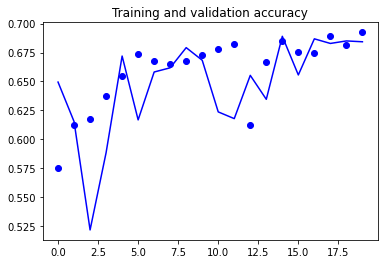

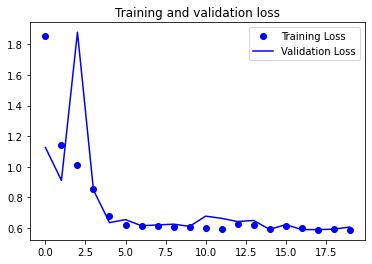

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model2.evaluate(test_data,  test_labels, verbose=2)
print('\nTest model1 accuracy:', test_acc)

2756/2756 - 0s - loss: 0.6169 - acc: 0.6713

Test model1 accuracy: 0.6712627


Melhor que a rede de regressão logitica simples

##3. Treine as seguintes arquiteturas de CNN:

  Todas as camadas convolucionais devem ser seguidas de Max Pooling com filtro 2x2. Teste diferentes quantidades de neurônios para a camada densa.

###  * Uma única camada com 32 filtros 3x3

In [0]:
import tensorflow as tf

In [0]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 119072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               15241344  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 15,242,369
Trainable params: 15,242,369
Non-trainable params: 0
_________________________________________________________________


In [0]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model3.fit(
      train_data, train_labels,
      epochs=5,
      validation_data=(val_data, val_labels),
      verbose=1,
      batch_size=32)

Train on 22046 samples, validate on 2756 samples
Epoch 1/5
22046/22046 [==============================] - 35s 2ms/sample - loss: 0.6262 - acc: 0.6661 - val_loss: 0.5198 - val_acc: 0.7583
Epoch 2/5
22046/22046 [==============================] - 35s 2ms/sample - loss: 0.3722 - acc: 0.8475 - val_loss: 0.3473 - val_acc: 0.8509
Epoch 3/5
22046/22046 [==============================] - 35s 2ms/sample - loss: 0.2007 - acc: 0.9283 - val_loss: 0.2751 - val_acc: 0.8882
Epoch 4/5
22046/22046 [==============================] - 36s 2ms/sample - loss: 0.1155 - acc: 0.9605 - val_loss: 0.3835 - val_acc: 0.8803
Epoch 5/5
22046/22046 [==============================] - 35s 2ms/sample - loss: 0.0604 - acc: 0.9805 - val_loss: 0.3667 - val_acc: 0.8759


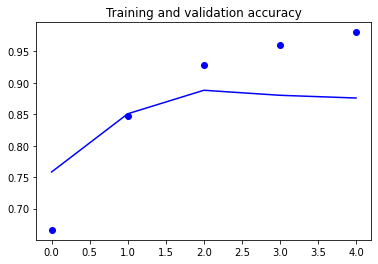

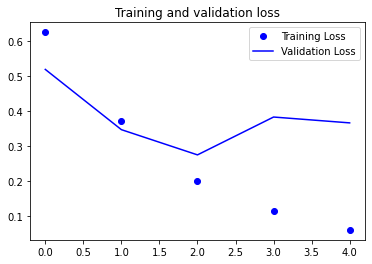

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model3.evaluate(test_data,  test_labels, verbose=2)
print('\nTest model1 accuracy:', test_acc)

2756/2756 - 1s - loss: 0.3722 - acc: 0.8886

Test model1 accuracy: 0.88860667


###  * Duas camadas com 32 filtros 3x3

In [0]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 123, 123, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 26912)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3444864   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [0]:
model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model4.fit(
      train_data, train_labels,
      epochs=5,
      validation_data=(val_data, val_labels),
      verbose=1)

Train on 22046 samples, validate on 2756 samples
Epoch 1/5
22046/22046 [==============================] - 43s 2ms/sample - loss: 0.4637 - acc: 0.7681 - val_loss: 0.2622 - val_acc: 0.9031
Epoch 2/5
22046/22046 [==============================] - 42s 2ms/sample - loss: 0.2113 - acc: 0.9288 - val_loss: 0.1960 - val_acc: 0.9318
Epoch 3/5
22046/22046 [==============================] - 42s 2ms/sample - loss: 0.1644 - acc: 0.9428 - val_loss: 0.2047 - val_acc: 0.9365
Epoch 4/5
22046/22046 [==============================] - 42s 2ms/sample - loss: 0.1273 - acc: 0.9550 - val_loss: 0.2006 - val_acc: 0.9325
Epoch 5/5
22046/22046 [==============================] - 42s 2ms/sample - loss: 0.0877 - acc: 0.9695 - val_loss: 0.2521 - val_acc: 0.9267


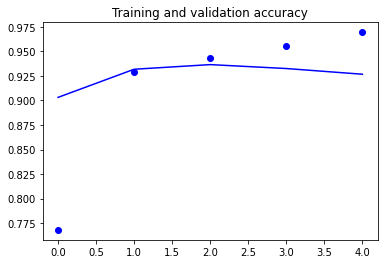

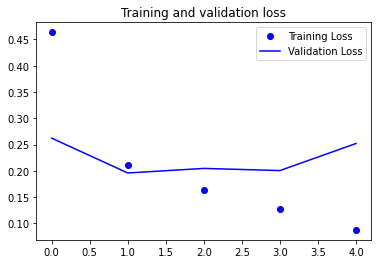

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model4.evaluate(test_data,  test_labels, verbose=2)
print('\nTest model1 accuracy:', test_acc)

2756/2756 - 1s - loss: 0.2279 - acc: 0.9419

Test model1 accuracy: 0.94194484


###  * Três camadas: duas de 32 filtros 3x3 e uma de 64 filtros 3x3

In [0]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 123, 123, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)            

In [0]:
model5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model5.fit(
      train_data, train_labels,
      epochs=5,
      validation_data=(val_data, val_labels),
      verbose=1)

Train on 22046 samples, validate on 2756 samples
Epoch 1/5
22046/22046 [==============================] - 47s 2ms/sample - loss: 0.3233 - acc: 0.8529 - val_loss: 0.1757 - val_acc: 0.9325
Epoch 2/5
22046/22046 [==============================] - 47s 2ms/sample - loss: 0.1517 - acc: 0.9522 - val_loss: 0.1419 - val_acc: 0.9517
Epoch 3/5
22046/22046 [==============================] - 48s 2ms/sample - loss: 0.1250 - acc: 0.9590 - val_loss: 0.1355 - val_acc: 0.9499
Epoch 4/5
22046/22046 [==============================] - 47s 2ms/sample - loss: 0.1103 - acc: 0.9627 - val_loss: 0.1348 - val_acc: 0.9561
Epoch 5/5
22046/22046 [==============================] - 48s 2ms/sample - loss: 0.0916 - acc: 0.9670 - val_loss: 0.1422 - val_acc: 0.9532


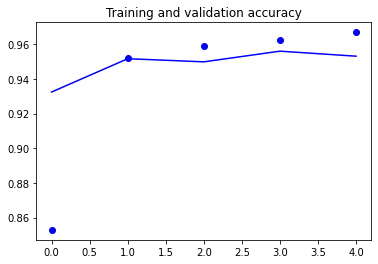

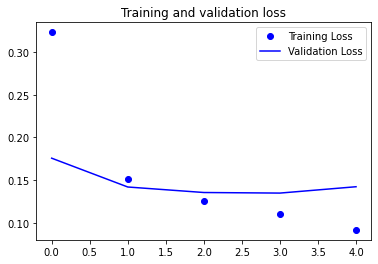

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model5.evaluate(test_data,  test_labels, verbose=2)
print('\nTest model1 accuracy:', test_acc)

2756/2756 - 1s - loss: 0.1573 - acc: 0.9572

Test model1 accuracy: 0.9571843


###  * Quatro camadas: duas de 32 filtros 3x3 e duas de 64 filtros 3x3


In [0]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 123, 123, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)       

In [0]:
model6.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model6.fit(
      train_data, train_labels,
      epochs=5,
      validation_data=(val_data, val_labels),
      verbose=1)

Train on 22046 samples, validate on 2756 samples
Epoch 1/5
22046/22046 [==============================] - 49s 2ms/sample - loss: 0.3629 - acc: 0.8136 - val_loss: 0.1811 - val_acc: 0.9390
Epoch 2/5
22046/22046 [==============================] - 49s 2ms/sample - loss: 0.1635 - acc: 0.9468 - val_loss: 0.1521 - val_acc: 0.9463
Epoch 3/5
22046/22046 [==============================] - 50s 2ms/sample - loss: 0.1466 - acc: 0.9506 - val_loss: 0.1429 - val_acc: 0.9478
Epoch 4/5
22046/22046 [==============================] - 50s 2ms/sample - loss: 0.1377 - acc: 0.9536 - val_loss: 0.1394 - val_acc: 0.9532
Epoch 5/5
22046/22046 [==============================] - 49s 2ms/sample - loss: 0.1290 - acc: 0.9562 - val_loss: 0.1321 - val_acc: 0.9536


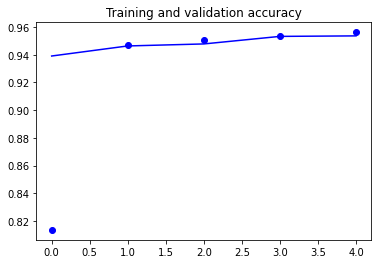

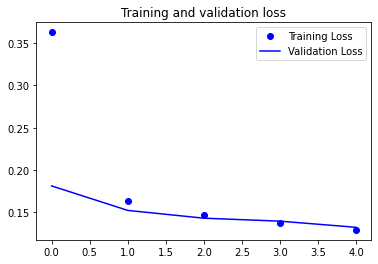

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model6.evaluate(test_data,  test_labels, verbose=2)
print('\nTest model1 accuracy:', test_acc)

2756/2756 - 2s - loss: 0.1507 - acc: 0.9485

Test model1 accuracy: 0.9484761


Este é o melhor modelo até o momento com menor overfitting, apresar a acuracia do test ser um pouco menor.

##4. Utilize Data Augmentation para tentar melhorar os resultados encontrados.

In [0]:
train_generator2 = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_generator2 = ImageDataGenerator(rescale=1./255)

test_generator2 = ImageDataGenerator(rescale=1./255)

In [0]:
train_datagen2 = train_generator2.flow_from_directory('./malaria/train',
                                                    target_size=(125, 125),
                                                    #batch_size=TRAIN_BATCH,
                                                    batch_size=512,
                                                    class_mode='binary')

train_datagen2 = train_generator2.flow_from_directory('./malaria/train',
                                                    target_size=(125, 125),
                                                    #batch_size=TRAIN_BATCH,
                                                    batch_size=512,
                                                    class_mode='binary')

val_datagen2 = val_generator2.flow_from_directory('./malaria/val',
                                                  target_size=(125,125),
                                                  batch_size=512,
                                                  class_mode='binary')

test_datagen2 = test_generator2.flow_from_directory('./malaria/val',
                                                  target_size=(125,125),
                                                  batch_size=512,
                                                  class_mode='binary')
test_data2, test_labels2 = test_datagen2.next()

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [0]:
model7 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
print(TRAIN_BATCH)
print(VAL_BATCH)

22048
2756


In [0]:
model7.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model7.fit_generator(
      train_datagen2,
      steps_per_epoch=TRAIN_BATCH/512,  
      epochs=5,
      validation_data=val_datagen2,
      validation_steps=VAL_BATCH/512,  
      verbose=1)

Epoch 1/5
44/43 [==============================] - 122s 3s/step - loss: 0.6448 - acc: 0.6281 - val_loss: 0.6493 - val_acc: 0.7039
Epoch 2/5
44/43 [==============================] - 117s 3s/step - loss: 0.5130 - acc: 0.7696 - val_loss: 0.3893 - val_acc: 0.8480
Epoch 3/5
44/43 [==============================] - 118s 3s/step - loss: 0.3464 - acc: 0.8514 - val_loss: 0.2972 - val_acc: 0.9078
Epoch 4/5
44/43 [==============================] - 121s 3s/step - loss: 0.3179 - acc: 0.8715 - val_loss: 0.3218 - val_acc: 0.8719
Epoch 5/5
44/43 [==============================] - 122s 3s/step - loss: 0.3017 - acc: 0.8758 - val_loss: 0.2457 - val_acc: 0.9104


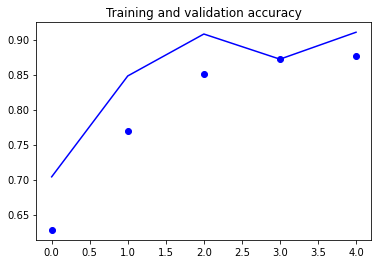

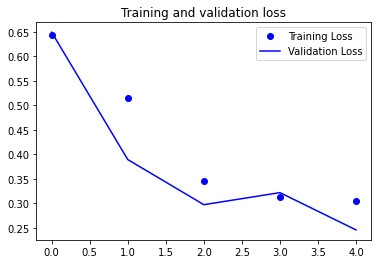

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model7.evaluate(test_data2,  test_labels2, verbose=2)
print('\nTest model1 accuracy:', test_acc)

512/512 - 0s - loss: 0.1932 - acc: 0.9141

Test model1 accuracy: 0.9140625


O resultado da acuracia neste caso foi pior com o data augmentation do que sem para o modelo com quatro camadas escondidas. 

##**Bônus**: Utilize algumas técnicas para tratamento de overfitting nas redes criadas (e.g. L1, L2 e Dropout). 

###Com Data Augmentation

####Usando L1 e dropout juntos

In [0]:
from keras import regularizers

In [0]:
model8 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model8.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model8.fit_generator(
      train_datagen2,
      steps_per_epoch=TRAIN_BATCH/512,  
      epochs=5,
      validation_data=val_datagen2,
      validation_steps=VAL_BATCH/512,  
      verbose=1)

Epoch 1/5
44/43 [==============================] - 128s 3s/step - loss: 46.0174 - acc: 0.4983 - val_loss: 15.5262 - val_acc: 0.5000
Epoch 2/5
44/43 [==============================] - 126s 3s/step - loss: 5.3123 - acc: 0.5003 - val_loss: 1.9667 - val_acc: 0.5000
Epoch 3/5
44/43 [==============================] - 125s 3s/step - loss: 1.3120 - acc: 0.4983 - val_loss: 1.2453 - val_acc: 0.5000
Epoch 4/5
44/43 [==============================] - 125s 3s/step - loss: 1.0777 - acc: 0.4981 - val_loss: 1.1741 - val_acc: 0.5000
Epoch 5/5
44/43 [==============================] - 126s 3s/step - loss: 1.0431 - acc: 0.5009 - val_loss: 1.1543 - val_acc: 0.5000


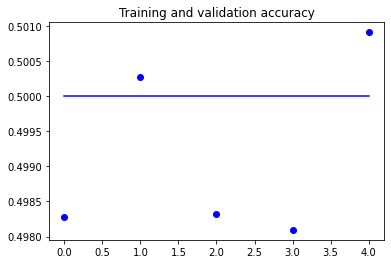

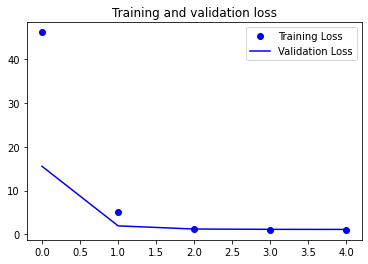

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model8.evaluate(test_data2,  test_labels2, verbose=2)
print('\nTest model1 accuracy:', test_acc)

512/512 - 0s - loss: 1.0356 - acc: 0.4863

Test model1 accuracy: 0.48632812


Não treina.

####Usando L1

In [0]:
model9 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model9.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model9.fit_generator(
      train_datagen2,
      steps_per_epoch=TRAIN_BATCH/512,  
      epochs=5,
      validation_data=val_datagen2,
      validation_steps=VAL_BATCH/512,  
      verbose=1)

Epoch 1/5
44/43 [==============================] - 127s 3s/step - loss: 43.6285 - acc: 0.5043 - val_loss: 13.2921 - val_acc: 0.5000
Epoch 2/5
44/43 [==============================] - 125s 3s/step - loss: 4.4645 - acc: 0.4942 - val_loss: 1.6920 - val_acc: 0.5000
Epoch 3/5
44/43 [==============================] - 125s 3s/step - loss: 1.1711 - acc: 0.4951 - val_loss: 1.1591 - val_acc: 0.5000
Epoch 4/5
44/43 [==============================] - 124s 3s/step - loss: 1.0301 - acc: 0.4991 - val_loss: 1.1448 - val_acc: 0.5000
Epoch 5/5
44/43 [==============================] - 124s 3s/step - loss: 1.0259 - acc: 0.4987 - val_loss: 1.1417 - val_acc: 0.5000


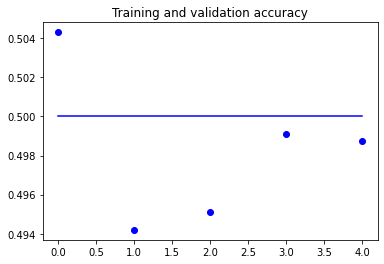

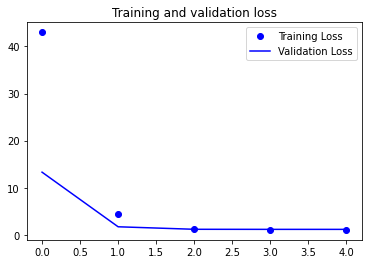

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model9.evaluate(test_data2,  test_labels2, verbose=2)
print('\nTest model1 accuracy:', test_acc)

512/512 - 0s - loss: 1.0243 - acc: 0.4863

Test model1 accuracy: 0.48632812


####Com droput

In [0]:
model10 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model10.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model10.fit_generator(
      train_datagen2,
      steps_per_epoch=TRAIN_BATCH/512,  
      epochs=5,
      validation_data=val_datagen2,
      validation_steps=VAL_BATCH/512,  
      verbose=1)

Epoch 1/5
44/43 [==============================] - 126s 3s/step - loss: 0.7267 - acc: 0.5022 - val_loss: 0.7726 - val_acc: 0.5000
Epoch 2/5
44/43 [==============================] - 125s 3s/step - loss: 0.6926 - acc: 0.5054 - val_loss: 0.7725 - val_acc: 0.5000
Epoch 3/5
44/43 [==============================] - 128s 3s/step - loss: 0.6831 - acc: 0.5660 - val_loss: 0.7532 - val_acc: 0.5853
Epoch 4/5
44/43 [==============================] - 126s 3s/step - loss: 0.6593 - acc: 0.6136 - val_loss: 0.7517 - val_acc: 0.5000
Epoch 5/5
44/43 [==============================] - 125s 3s/step - loss: 0.6245 - acc: 0.6651 - val_loss: 0.7327 - val_acc: 0.5000


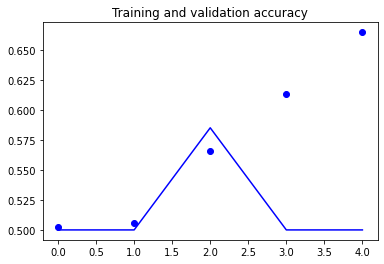

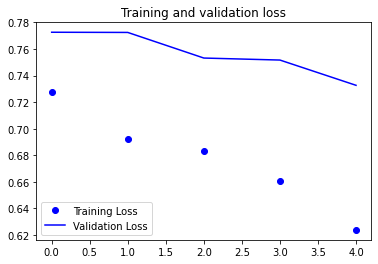

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model10.evaluate(test_data2,  test_labels2, verbose=2)
print('\nTest model1 accuracy:', test_acc)

512/512 - 0s - loss: 0.6502 - acc: 0.5137

Test model1 accuracy: 0.5136719


###Sem Data Augmentation

####Usando L1 e dropout juntos

In [0]:
model11 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model11.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model11.fit(
      train_data, train_labels,
      epochs=5,
      validation_data=(val_data, val_labels),
      verbose=1)

Train on 22046 samples, validate on 2756 samples
Epoch 1/5
22046/22046 [==============================] - 75s 3ms/sample - loss: 4.4485 - acc: 0.4922 - val_loss: 1.0231 - val_acc: 0.5000
Epoch 2/5
22046/22046 [==============================] - 74s 3ms/sample - loss: 1.0232 - acc: 0.5016 - val_loss: 1.0231 - val_acc: 0.5000
Epoch 3/5
22046/22046 [==============================] - 74s 3ms/sample - loss: 1.0236 - acc: 0.4978 - val_loss: 1.0232 - val_acc: 0.5000
Epoch 4/5
22046/22046 [==============================] - 74s 3ms/sample - loss: 1.0237 - acc: 0.5019 - val_loss: 1.0233 - val_acc: 0.5000
Epoch 5/5
22046/22046 [==============================] - 73s 3ms/sample - loss: 1.0237 - acc: 0.4943 - val_loss: 1.0232 - val_acc: 0.5000


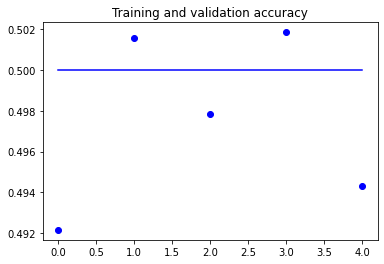

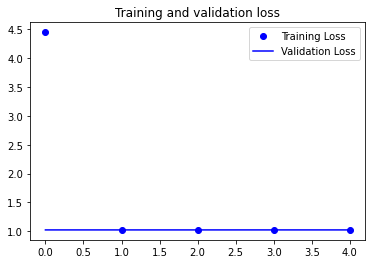

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model11.evaluate(test_data,  test_labels, verbose=2)
print('\nTest model9 accuracy:', test_acc)

2756/2756 - 4s - loss: 1.0232 - acc: 0.5000

Test model9 accuracy: 0.5


Não treina

####Com L1

In [0]:
model12 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3),kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model12.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model12.fit(
      train_data, train_labels,
      epochs=5,
      validation_data=(val_data, val_labels),
      verbose=1)

Train on 22046 samples, validate on 2756 samples
Epoch 1/5
22046/22046 [==============================] - 65s 3ms/sample - loss: 3.9824 - acc: 0.4986 - val_loss: 1.0229 - val_acc: 0.5000
Epoch 2/5
22046/22046 [==============================] - 64s 3ms/sample - loss: 1.0237 - acc: 0.4909 - val_loss: 1.0208 - val_acc: 0.5000
Epoch 3/5
22046/22046 [==============================] - 65s 3ms/sample - loss: 1.0237 - acc: 0.5007 - val_loss: 1.0224 - val_acc: 0.5000
Epoch 4/5
22046/22046 [==============================] - 64s 3ms/sample - loss: 1.0236 - acc: 0.5000 - val_loss: 1.0223 - val_acc: 0.5000
Epoch 5/5
22046/22046 [==============================] - 64s 3ms/sample - loss: 1.0235 - acc: 0.5015 - val_loss: 1.0250 - val_acc: 0.5000


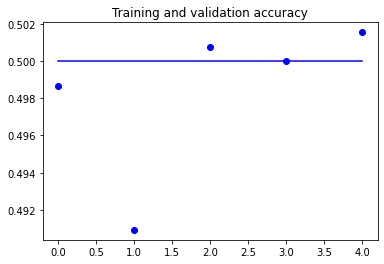

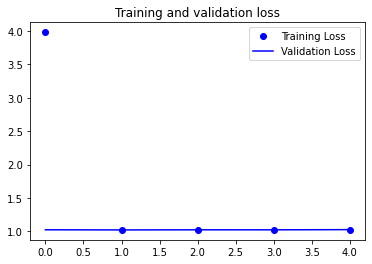

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model12.evaluate(test_data,  test_labels, verbose=2)
print('\nTest model1 accuracy:', test_acc)

2756/2756 - 3s - loss: 1.0250 - acc: 0.5000

Test model1 accuracy: 0.5


####Com dropout

In [0]:
model13 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(125, 125, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model13.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model13.fit(
      train_data, train_labels,
      epochs=5,
      validation_data=(val_data, val_labels),
      verbose=1)

Train on 22046 samples, validate on 2756 samples
Epoch 1/5
22046/22046 [==============================] - 75s 3ms/sample - loss: 0.4934 - acc: 0.7427 - val_loss: 0.2272 - val_acc: 0.9180
Epoch 2/5
22046/22046 [==============================] - 73s 3ms/sample - loss: 0.2195 - acc: 0.9245 - val_loss: 0.1845 - val_acc: 0.9412
Epoch 3/5
22046/22046 [==============================] - 73s 3ms/sample - loss: 0.2026 - acc: 0.9351 - val_loss: 0.1941 - val_acc: 0.9412
Epoch 4/5
22046/22046 [==============================] - 72s 3ms/sample - loss: 0.1864 - acc: 0.9409 - val_loss: 0.1987 - val_acc: 0.9412
Epoch 5/5
22046/22046 [==============================] - 72s 3ms/sample - loss: 0.1793 - acc: 0.9422 - val_loss: 0.1908 - val_acc: 0.9430


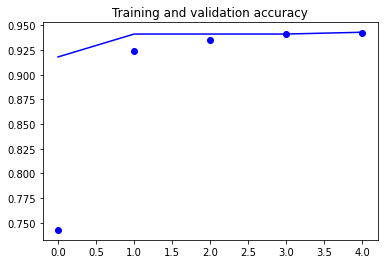

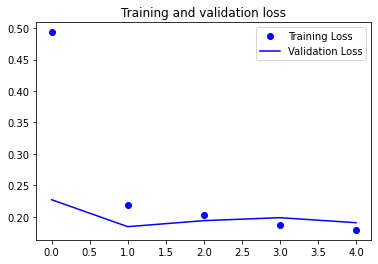

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model13.evaluate(test_data,  test_labels, verbose=2)
print('\nTest model13 accuracy:', test_acc)

2756/2756 - 3s - loss: 0.1888 - acc: 0.9445

Test model13 accuracy: 0.9444848


###Melhor Resultado

O modelo que obteve o melhor resultado foi o CNN de 4 camadas sem regularização e sem data augmentation.
* loss: 0.1507 - acc: 0.9485

Os resultados com regularização L1 foram bem ruins, provavelmente por causa do parametro passado.